# Capstone 3 - Data Collection

### Project Background
    
    Customer satisfaction at financial institutions is key to maintaining a good reputation but data may not always be leveraged as well as it can be. I remember when I supported a call center function at a large bank, the leaders of the call center would personally read individual complaints to try and glean valuable information and take action accordingly. Using NLP to analyze the type and severity of complaints can uncover serious issues with certain business functions that are negatively impacting customer satisfaction.
    
### Data

    The data I used in this project came from the Consumer Financial Protection Bureau complaints dataset consisting of 1.8 million complaints, of which about 600k had written complaints. 
    
### Machine Learning Methods

    I plan to use Natural Language Processing to classify the product alignment of each complaint as well as the severity. This will not only give me information on what business function is driving the highest number of complaints, but will also direct me to which ones are most serious and where I must first direct my attention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from time import time
from collections import Counter
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from gensim.corpora.dictionary import Dictionary
import gensim
import pyLDAvis.gensim
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# folder directory to save file
save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/"
fig_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/figures/"
proc_data_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/data/processed/"

In [3]:
large = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip' # 1.8m rows
banks = ['CITIBANK, N.A.', 
         'JPMORGAN CHASE & CO.', 
         'WELLS FARGO & COMPANY', 
         'BANK OF AMERICA, NATIONAL ASSOCIATION']

#read in larget dataset - 1.8m rows - 19000 from chase
df_banks = pd.read_csv(large)
# only include values from top 4 banks in list banks (exclude credit bureaus and smaller institutions)
df_banks = df_banks[df_banks.Company.isin(banks)]

In [4]:
df_banks.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
11,2019-04-29,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,NaN,NaN,JPMORGAN CHASE & CO.,NY,10452,NaN,Consent not provided,Web,2019-04-29,Closed with monetary relief,Yes,NaN,3226093
29,2020-10-01,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,JPMORGAN CHASE & CO.,NY,12549,NaN,NaN,Referral,2020-10-02,Closed with explanation,Yes,NaN,3879354
41,2019-05-10,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",NJ,07470,NaN,Consent not provided,Web,2019-05-10,Closed with explanation,Yes,NaN,3238261
54,2020-10-08,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,77071,NaN,NaN,Phone,2020-10-08,Closed with explanation,Yes,NaN,3888551
87,2019-02-16,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,On XX/XX/XXXX I received a letter from the IRS...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,956XX,NaN,Consent provided,Web,2019-02-16,Closed with non-monetary relief,Yes,NaN,3154014


In [5]:
# drop rows without a written complaint
df_banks = df_banks.dropna(subset=['Consumer complaint narrative']).reset_index(drop=True)
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77751 entries, 0 to 77750
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 77751 non-null  object
 1   Product                       77751 non-null  object
 2   Sub-product                   69467 non-null  object
 3   Issue                         77751 non-null  object
 4   Sub-issue                     42299 non-null  object
 5   Consumer complaint narrative  77751 non-null  object
 6   Company public response       57148 non-null  object
 7   Company                       77751 non-null  object
 8   State                         77175 non-null  object
 9   ZIP code                      60389 non-null  object
 10  Tags                          14559 non-null  object
 11  Consumer consent provided?    77751 non-null  object
 12  Submitted via                 77751 non-null  object
 13  Date sent to com

In [6]:
# drop needless columns
df_banks.drop(['Date received', 'Sub-product', 'Sub-issue', 'ZIP code', 'Tags', 'Consumer consent provided?',
        'Submitted via', 'Date sent to company', 'Timely response?', "Company public response", 'State'], 
        axis=1, inplace=True)

In [7]:
# rename columns to remove spaces
df_banks = df_banks.rename(columns={"Consumer complaint narrative": "complaint_text", 
                                    "Company response to consumer":"company_response",
                                    "Consumer disputed?":"disputed",
                                    "Complaint ID":"complaint_ID"})


In [8]:
# convert 'disputed' column to int instead of 'yes'/'no'
df_banks['disputed'] = [1 if b=='Yes' else 0 for b in df_banks.disputed]

df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77751 entries, 0 to 77750
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Product           77751 non-null  object
 1   Issue             77751 non-null  object
 2   complaint_text    77751 non-null  object
 3   Company           77751 non-null  object
 4   company_response  77751 non-null  object
 5   disputed          77751 non-null  int64 
 6   complaint_ID      77751 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.2+ MB


In [9]:
# different products - notice duplication (i.e. 'payday loan' and 'payday loan, title loan, or personal loan')
df_banks['Product'].value_counts()

Credit card or prepaid card                                                     16349
Mortgage                                                                        15862
Checking or savings account                                                     12723
Credit card                                                                      8126
Bank account or service                                                          7305
Credit reporting, credit repair services, or other personal consumer reports     6876
Debt collection                                                                  4584
Money transfer, virtual currency, or money service                               2187
Vehicle loan or lease                                                            1002
Consumer Loan                                                                     982
Student loan                                                                      852
Payday loan, title loan, or personal loan             

In [10]:
# consolidate duplicative products
df_banks.loc[df_banks.Product == 'Mortgage', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Student Loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Payday loan, title loan, or personal loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Payday loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Vehicle loan or lease', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Student loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Prepaid card', ['Product']] = 'Credit card or prepaid card'
df_banks.loc[df_banks.Product == 'Money transfers', ['Product']] = 'Other financial service'
df_banks.loc[df_banks.Product == 'Credit reporting, credit repair services, or other personal consumer reports', ['Product']] = 'Credit reporting'
df_banks.loc[df_banks.Product == 'Credit card', ['Product']] = 'Credit card or prepaid card'
df_banks.loc[df_banks.Product == 'Checking or savings account', ['Product']] = 'Bank account or service'
df_banks.loc[df_banks.Product == 'Virtual currency', ['Product']] = 'Other financial service'
df_banks.loc[df_banks.Product == 'Money transfer, virtual currency, or money service', ['Product']] = 'Other financial service'

df_banks.Product.value_counts()

Credit card or prepaid card    24591
Bank account or service        20028
Consumer Loan                  19085
Credit reporting                7020
Debt collection                 4584
Other financial service         2443
Name: Product, dtype: int64

In [11]:
# check for duplicates
duplicateRowsDF = df_banks[df_banks.duplicated()]
print('Duplicate rows: ', len(duplicateRowsDF))
# drop duplicates
df_banks.drop_duplicates(keep='first', inplace=True)
duplicateRowsDF = df_banks[df_banks.duplicated()]
print('Duplicate rows: ', len(duplicateRowsDF))

Duplicate rows:  0
Duplicate rows:  0


In [13]:
# Feature Engineering - Create column for # of sentences in complaint

sent_tokens = [sent_tokenize(item) for item in df_banks.complaint_text]
len_sent_tokens = []

for i in range(len(sent_tokens)):
    len_sent_tokens.append(len(sent_tokens[i]))

df_banks['sentences'] = len_sent_tokens


In [14]:
# Feature Engineering - Create column for # of words in complaint

word_tokens = [word_tokenize(item) for item in df_banks.complaint_text]
len_word_tokens = []

for i in range(len(word_tokens)):
    len_word_tokens.append(len(word_tokens[i]))

df_banks['words'] = len_word_tokens


In [15]:
# Feature Engineering - Create column for # of ? and ! in complaint

df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')
df_banks.iloc[0,2]


<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<ipython-input-15-60a143344ebe>:3: DeprecationWarning: invalid escape sequence \!
  df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')
<ipython-input-15-60a143344ebe>:3: DeprecationWarning: invalid escape sequence \?
  df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')


'On XX/XX/XXXX I received a letter from the IRS stating my identity may have been compromised. My name is XXXX XXXX and I was XXXX yrs old at the time and a college student. My mom & I sat down as I returned from college and pulled my credit report. Discovered after pulling the Free Annual Credit Report that another person, XXXX XXXX  XXXX, and a car loan & credit card that were not mine were on my credit report. It should be noted it was only on XXXX. We contacted XXXX & Wells Fargo bank to report the fraudulent accounts. They did confirm it was my SS # on file but with someone elses name, DOB, and address. We filled out fraud forms, send police report number, and copies of credit reports. On XX/XX/XXXX & XX/XX/XXXX I received letters from both Wells Fargo & XXXX stating it was discovered to be identity theft and they would have the 3 credit bureaus remove from my credit file. I also placed a freeze on my credit files. \n\nOn XX/XX/XXXX I received a few voicemails from SS office stati

In [16]:
round(df_banks.describe().T,3)

,count,mean,std,min,25%,50%,75%,max
disputed,77751.0,0.084,0.278,0.0,0.0,0.0,0.0,1.0
complaint_ID,77751.0,2716282.794,724622.782,1290200.0,2129229.5,2798761.0,3308492.0,3998907.0
sentences,77751.0,11.910,11.814,1.0,5.0,9.0,15.0,290.0
words,77751.0,273.781,278.208,2.0,108.0,198.0,348.0,5965.0
special_chars,77751.0,0.669,2.564,0.0,0.0,0.0,0.0,194.0


In [17]:
# words to remove from stop words
stop_remove = ['no', 'not', "don't"]
stop_add = ['xx', 'xxxx', '00']

def add_or_remove_stop_words(remove_list, add_list):
    '''adding or removing multiple stop words instead of repetitive code'''
    
    global STOP_WORDS
    STOP_WORDS = stopwords.words('english')
    for i in range(len(remove_list)):
        STOP_WORDS.remove(remove_list[i])
    
    for i in range(len(add_list)):
        STOP_WORDS.append(add_list[i])
    
# remove negation stop words
add_or_remove_stop_words(stop_remove, stop_add)


In [18]:
# text preprocessing formulas
def preprocess_text(text):
    '''tokenize, lemmatize and remove stop words from text'''
    
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    bigram = list(ngrams(tokens, 2)) 
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in STOP_WORDS]
    
    #convert text back to string
    text_str = " ".join(keywords)
    return text_str

In [19]:
# Get the polarity score of each complaint
def get_TextBlob_polarity(text):
    '''Assign polarity score between -1 to 1 for text'''
    
    polarity = TextBlob(text).sentiment.polarity
    return polarity

def get_TextBlob_subjectivity(text):
    '''Assign polarity score between -1 to 1 for text'''
    
    subjectivity = TextBlob(text).sentiment.subjectivity
    return subjectivity

In [20]:
# Preprocess complaint_text column then run the textblob polarity 
df_banks['preprocessed_complaint'] = df_banks.complaint_text.apply(preprocess_text)

df_banks['polarity'] = [get_TextBlob_polarity(str(complaint)) for complaint in df_banks.preprocessed_complaint]
df_banks['subjectivity'] = [get_TextBlob_subjectivity(str(complaint)) for complaint in df_banks.preprocessed_complaint]


In [21]:
print(df_banks.subjectivity.nsmallest())
print(df_banks.subjectivity.nlargest())

27     0.0
45     0.0
79     0.0
117    0.0
132    0.0
Name: subjectivity, dtype: float64
34      1.0
128     1.0
169     1.0
1175    1.0
1735    1.0
Name: subjectivity, dtype: float64


In [22]:
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77751 entries, 0 to 77750
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 77751 non-null  object 
 1   Issue                   77751 non-null  object 
 2   complaint_text          77751 non-null  object 
 3   Company                 77751 non-null  object 
 4   company_response        77751 non-null  object 
 5   disputed                77751 non-null  int64  
 6   complaint_ID            77751 non-null  int64  
 7   sentences               77751 non-null  int64  
 8   words                   77751 non-null  int64  
 9   special_chars           77751 non-null  int64  
 10  preprocessed_complaint  77751 non-null  object 
 11  polarity                77751 non-null  float64
 12  subjectivity            77751 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 10.8+ MB


In [23]:
print(df_banks.polarity.nsmallest())
print(df_banks.polarity.nlargest())

5028    -1.0
13226   -1.0
33984   -1.0
34210   -1.0
46714   -1.0
Name: polarity, dtype: float64
2566    1.0
3759    1.0
4021    1.0
4807    1.0
5924    1.0
Name: polarity, dtype: float64


In [24]:
print('Most positive review: ', df_banks.iloc[df_banks.polarity.idxmax(),10])
print()
print('Most Negative Review: ', df_banks.iloc[df_banks.polarity.idxmin(),10])

Most positive review:  come attention theres incorrect information account not mine never mine ive never cosign allow information use heres account 1 cbna 190 xxxx2 0 3 0 xxxx4 best buy cbna 240 5 macys dsnb 500 07 2017 6 verizon 1000 06 2017 7 amsher 160 8 1000

Most Negative Review:  citi bank horrible electronic systems upload document verification apply 2019 accelerate save account get email upload wifes drivers license upload docs via docusign system receive confirmation noon get another email yet another email 7 email ask upload docs despite upload docs 3 time still 2 weeks get letter date account number no debit card try reach via chat agent mention citi dispatch week ago 3 weeks still no debit card call agent mention wait license copy issue account number case agent lie us dispatch debit card well 3 weeks hassle stil dont debit card want close account citi tell write use info delete since no longer go customer


In [25]:
df_banks.head()

,Product,Issue,complaint_text,Company,company_response,disputed,complaint_ID,sentences,words,special_chars,preprocessed_complaint,polarity,subjectivity
0,Credit reporting,Incorrect information on your report,On XX/XX/XXXX I received a letter from the IRS...,WELLS FARGO & COMPANY,Closed with non-monetary relief,0,3154014,22,412,1,receive letter irs state identity may compromi...,0.069345,0.300595
1,Consumer Loan,Struggling to pay mortgage,I am filing this complaint after receiving a l...,JPMORGAN CHASE & CO.,Closed with explanation,0,3169014,18,468,1,file complaint receive letter chase today alle...,-0.175926,0.208333
2,Credit card or prepaid card,Problem with a purchase shown on your statement,"On XX/XX/XXXX, Bank of America mailed out a ca...","BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,0,3121663,7,171,0,bank america mail card new authorize user cred...,0.081061,0.388578
3,Bank account or service,Problem with a lender or other company chargin...,I made an appointment at XXXX for myself and a...,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with explanation,0,3128523,7,91,0,make appointment another person contract direc...,0.000000,0.316667
4,Credit card or prepaid card,Closing your account,I was using my chase credit card like a regula...,JPMORGAN CHASE & CO.,Closed with explanation,0,3288810,1,47,0,use chase credit card like regular credit card...,0.000000,0.076923


In [26]:
# create formula to apply sentiment intensity analyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    return score['compound']

In [27]:
# vader sentiment analysis to assess positive/negative as well as how negative a review is
df_banks['sentiment_vader'] = [sentiment_analyzer_scores(str(complaint)) for complaint in \
                               df_banks.preprocessed_complaint]

In [28]:
print(df_banks.sentiment_vader.nsmallest())
print(df_banks.sentiment_vader.nlargest())

35306   -0.9999
35434   -0.9996
6863    -0.9995
37196   -0.9994
4104    -0.9993
Name: sentiment_vader, dtype: float64
4895     0.9999
7180     0.9999
30311    0.9999
32369    0.9998
68299    0.9998
Name: sentiment_vader, dtype: float64


In [29]:
#print('Most positive review: ', df_banks.iloc[df_banks.sentiment_vader.idxmax(),2])
#print()
#print('Most Negative Review: ', df_banks.iloc[df_banks.sentiment_vader.idxmin(),2])
#print('Most Negative Review: ', df_banks.iloc[4091,2])
print('Most Positive Review: ', df_banks.iloc[31441,2])

Most Positive Review:  My husband and I have had a Wells Fargo Equity Line for {$35000.00} that we got XX/XX/XXXX. We mostly only paid the interest and racked up to {$35000.00} on it. It is past the 10 years and it was closed XX/XX/XXXX when we tried to refinance our home with Wells Fargo but that loan was denied by them. We still have been making interest payments with a annual financial rate of 6.35 % along with credit insurance. Due to limited funds, it is hard to make payments more than that. We recently talked with Wells Fargo trying to refinance and open another line of equity credit for the balance of {$34000.00} because that was the only way to lower the interest and change the time frame of the loan from 30 to 10/15 years. We were denied due to lack of liquid assets. Please help with verbiage in talking with Wells Fargo and what other options we have to get this loan paid off. Please let us now if you have other questions and advice. We currently have our Home Mortgage with XX

In [30]:
# Save DataFrame as csv to be used for EDA and Modeling
save = os.path.join(save_path, 'data/processed', 'DW_complaints.csv')
df_banks.to_csv(save)


# Capstone 3 - EDA

## Exploratory Data Analysis on complaints dataset

In [31]:
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77751 entries, 0 to 77750
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 77751 non-null  object 
 1   Issue                   77751 non-null  object 
 2   complaint_text          77751 non-null  object 
 3   Company                 77751 non-null  object 
 4   company_response        77751 non-null  object 
 5   disputed                77751 non-null  int64  
 6   complaint_ID            77751 non-null  int64  
 7   sentences               77751 non-null  int64  
 8   words                   77751 non-null  int64  
 9   special_chars           77751 non-null  int64  
 10  preprocessed_complaint  77751 non-null  object 
 11  polarity                77751 non-null  float64
 12  subjectivity            77751 non-null  float64
 13  sentiment_vader         77751 non-null  float64
dtypes: float64(3), int64(5), object(6)
mem

In [32]:
df_banks.Product.unique()

array(['Credit reporting', 'Consumer Loan', 'Credit card or prepaid card',
       'Bank account or service', 'Other financial service',
       'Debt collection'], dtype=object)

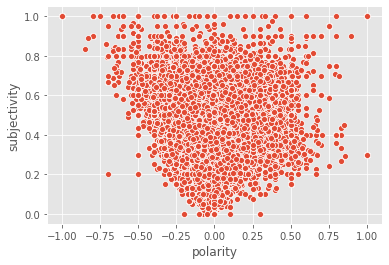

In [33]:
# show subjectivity against polarity for the complaints
sns.scatterplot(x='polarity', y='subjectivity', data=df_banks) #[df_banks.Product == 'Consumer Loan']
plt.show()

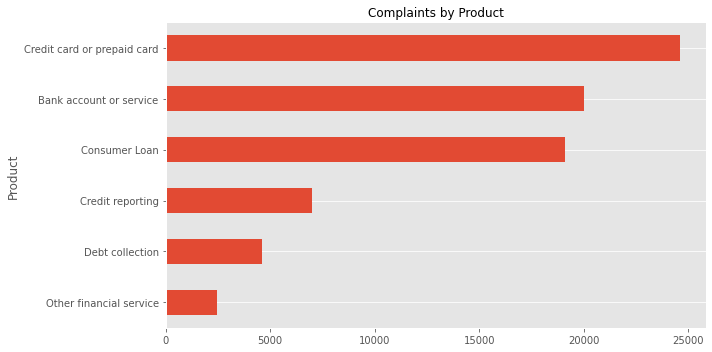

In [41]:
# number of complaints for each product
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Complaints by Product", fontsize=12)
df_banks["Product"].reset_index().groupby("Product").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.tight_layout()
plt.show()
fig.savefig(fig_save_path + 'complaints_by_product.png')

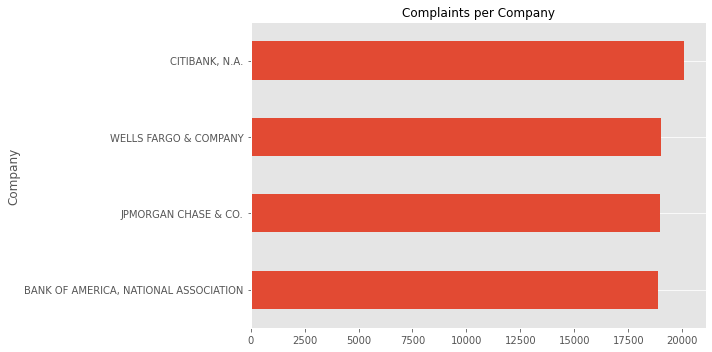

In [102]:
# number of complaints by bank
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Complaints per Company", fontsize=12)
df_banks["Company"].reset_index().groupby("Company").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.tight_layout()
plt.show()
fig.savefig(fig_save_path + 'complaints_by_company.png')

In [34]:
# formula to get top 20 ngrams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [35]:
# count top words
t0 = time()
most = Counter(" ".join(df_banks["preprocessed_complaint"]).split()).most_common(20)
df_most = pd.DataFrame(most, columns=['word', 'count'])

# top bigrams
top_n_bigrams = get_top_ngram(df_banks['preprocessed_complaint'], 2)
x_bi, y_bi = map(list, zip(*top_n_bigrams))

# top trigrams
top_n_trigrams=get_top_ngram(df_banks['preprocessed_complaint'], 3)
x_tri, y_tri = map(list,zip(*top_n_trigrams))
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

<Figure size 576x720 with 0 Axes>

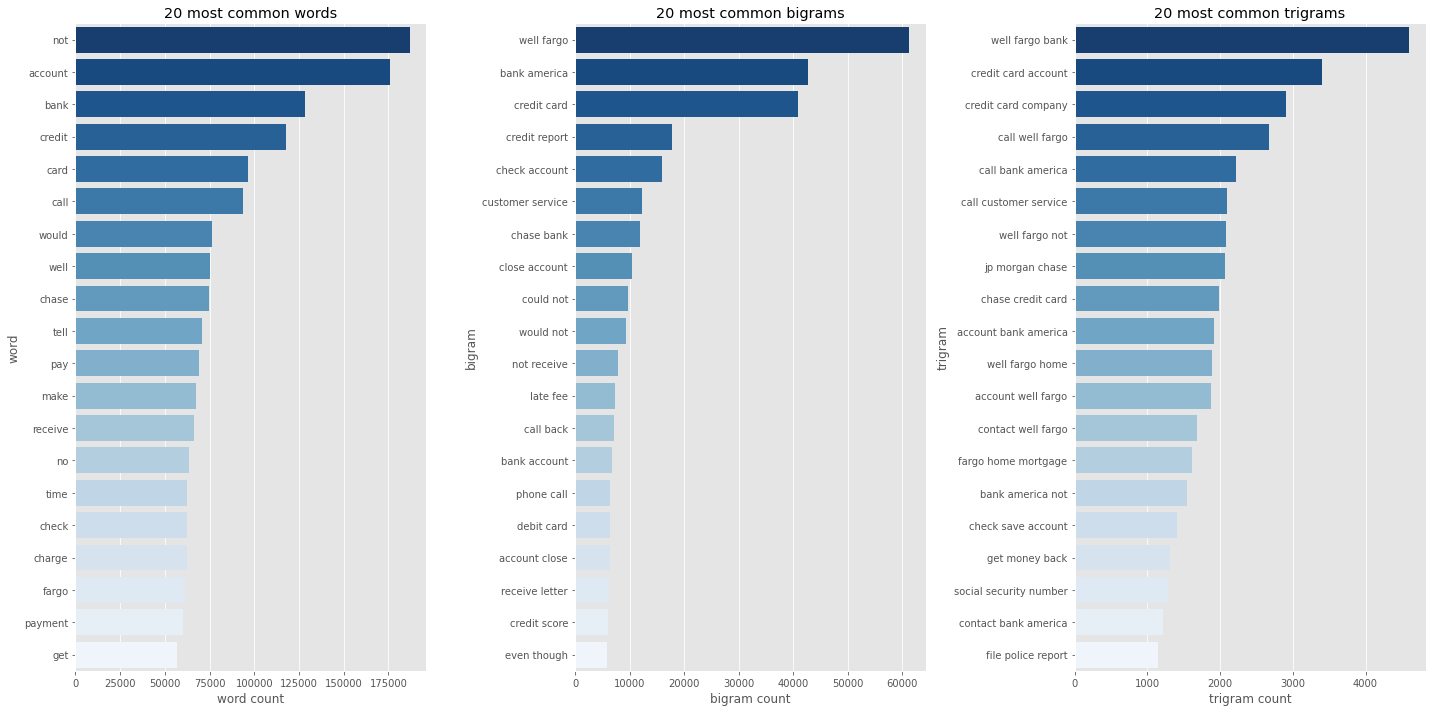

In [40]:
# most common words, bigrams and trigrams

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='count',y='word', data=df_most, palette='Blues_r')
ax1.set(title='20 most common words', xlabel='word count', ylabel='word')

ax2 = fig.add_subplot(1,3,2)
sns.barplot(x=y_bi, y=x_bi, palette='Blues_r')
ax2.set(title='20 most common bigrams', xlabel='bigram count', ylabel='bigram')

ax3 = fig.add_subplot(1,3,3)
sns.barplot(x=y_tri, y=x_tri, palette='Blues_r')
ax3.set(title='20 most common trigrams', xlabel='trigram count', ylabel='trigram')

plt.tight_layout()
plt.show()

fig.savefig(fig_save_path + 'words_bigrams_trigrams.png')


In [42]:
def get_lda_objects(text):
    '''create instance of Latent Dirichlet Allocation (LDA) model as well as bag-of-words and gensim dictionary to be used to train model'''
    stop = STOP_WORDS
    
    def _preprocess_text(text):
        '''preprocess test to create corpus'''
        corpus = []
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus = _preprocess_text(text)
    
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 6, 
                                   id2word = dic,                                    
                                   passes = 10)
                                   #workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    '''plot pyLDAvis visual for interactive view of topic clusters and relevant words'''
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [43]:
# get LDA objects to run 
t0 = time()
lda_model, bow_corpus, dic = get_lda_objects(df_banks.preprocessed_complaint)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Runtime: 12.0 minutes


In [44]:
# topic 4 shows words more related to customer service than specific business unit
lda_model.show_topics()

[(0,
  '0.018*"bank" + 0.015*"report" + 0.015*"not" + 0.012*"debt" + 0.011*"chase" + 0.011*"information" + 0.009*"provide" + 0.009*"america" + 0.009*"request" + 0.009*"credit"'),
 (1,
  '0.033*"call" + 0.027*"not" + 0.025*"card" + 0.025*"credit" + 0.018*"tell" + 0.018*"chase" + 0.017*"account" + 0.016*"say" + 0.014*"get" + 0.012*"would"'),
 (2,
  '0.052*"payment" + 0.035*"credit" + 0.031*"pay" + 0.028*"account" + 0.026*"fee" + 0.024*"charge" + 0.021*"balance" + 0.020*"not" + 0.017*"late" + 0.017*"make"'),
 (3,
  '0.030*"loan" + 0.028*"well" + 0.026*"fargo" + 0.022*"mortgage" + 0.021*"not" + 0.015*"home" + 0.013*"payment" + 0.010*"would" + 0.009*"time" + 0.009*"modification"'),
 (4,
  '0.026*"card" + 0.023*"citi" + 0.023*"not" + 0.023*"citibank" + 0.016*"receive" + 0.016*"charge" + 0.012*"dispute" + 0.012*"account" + 0.012*"credit" + 0.011*"offer"'),
 (5,
  '0.052*"account" + 0.047*"bank" + 0.035*"check" + 0.020*"not" + 0.020*"money" + 0.015*"america" + 0.014*"deposit" + 0.013*"fund" + 

In [45]:
# choose random complaint to see the topic allocation
df_banks.complaint_text[4311]

'This is my official request to have the aforementioned item to be deleted off my credit report ; This letter to dispute a claim that is falsely listed on my credit report with your bureau. \nBe advised this is not a refusal to pay, but a notice sent pursuant to the Fair Debt Collection Practices Act, 15 USC 1692g stating your claim is disputed and validation is requested. \nThis is NOT a request for verification or proof of my mailing address, but a request for VALIDATION made pursuant to the above-named Title and Section. I respectfully request your offices provide me with competent evidence that I have any legal obligation to pay you. \nAt this time, I will also inform you that if your offices have reported invalidated information to any of the 3 major credit bureaus ( XXXX, XXXX or XXXX ) this action may constitute fraud under both Federal and State Laws. Due to this fact, if any negative mark is found on any of my credit reports by your company or the company that you represent, I

In [46]:
# see topic alignment for specific complaint above
for index, score in sorted(lda_model[bow_corpus[4311]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9230206608772278	 
Topic: 0.018*"bank" + 0.015*"report" + 0.015*"not" + 0.012*"debt" + 0.011*"chase" + 0.011*"information" + 0.009*"provide" + 0.009*"america" + 0.009*"request" + 0.009*"credit"

Score: 0.07375562936067581	 
Topic: 0.033*"call" + 0.027*"not" + 0.025*"card" + 0.025*"credit" + 0.018*"tell" + 0.018*"chase" + 0.017*"account" + 0.016*"say" + 0.014*"get" + 0.012*"would"


In [47]:
# visual of LDA and different topics
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.054206 -0.045569       1        1  21.982393
3     -0.017358 -0.083209       2        1  19.557070
5      0.044439 -0.105090       3        1  18.413120
2      0.106673  0.103694       4        1  15.095079
0     -0.225869  0.039049       5        1  12.522250
4      0.037908  0.091125       6        1  12.430091, topic_info=        Term           Freq          Total Category  logprob  loglift
63   payment   92712.000000   92712.000000  Default  30.0000  30.0000
47      loan   52941.000000   52941.000000  Default  29.0000  29.0000
262    check   63276.000000   63276.000000  Default  28.0000  28.0000
10      card   96868.000000   96868.000000  Default  27.0000  27.0000
20    credit  117116.000000  117116.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
145    month    5814.385742   39210.554688   Topic6  -5.2345   0.1764
481    issue    5163.803711   27408.789062   Topic6  -5.3532   0.4159
83     state    5329.074707   37969.136719   Topic6  -5.3216   0.1215
176     tell    5540.771484   72530.710938   Topic6  -5.2827  -0.4868
189     call    5603.085449   95508.953125   Topic6  -5.2715  -0.7509

[542 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
5943       5  0.992944    1681
7720       5  0.995650    1692
2986       5  0.994416     623
11367      3  0.980344  880000
6857       1  0.965460     ___
...      ...       ...     ...
183        5  0.047354    year
183        6  0.025714    year
15264      3  0.994168     yen
16490      4  0.939803     zed
16490      6  0.039158     zed

[1436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 1, 5])

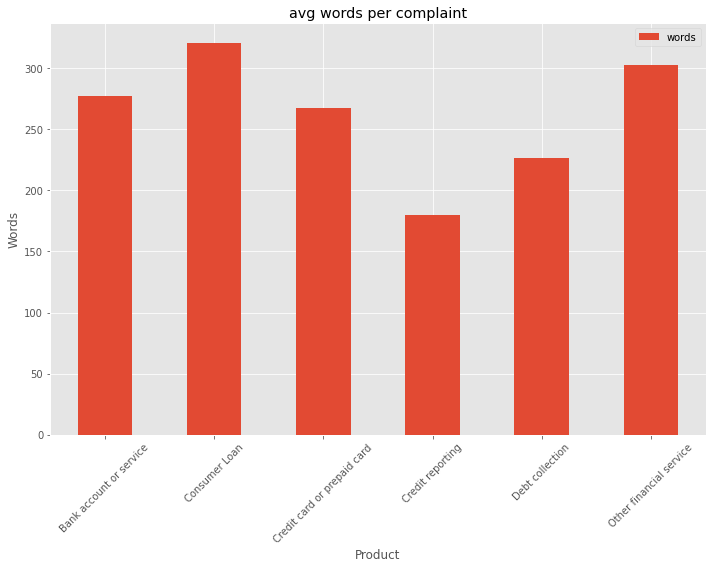

In [48]:
# show average words per complaint by product
df_banks_w = df_banks.groupby(['Product'])[['words']].mean().round(2)
df_banks_w.plot(kind='bar', figsize=(10,8), title='avg words per complaint', rot=45)
plt.xlabel('Product')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

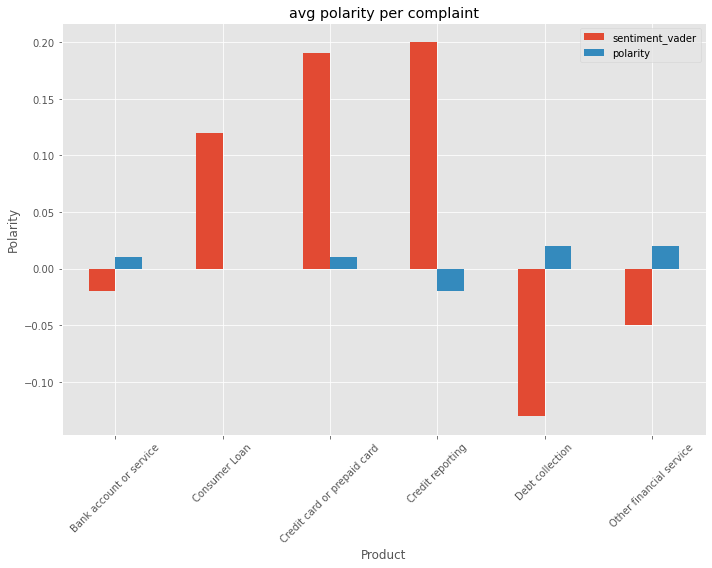

In [49]:
# average polarity by product
df_banks_s = df_banks.groupby(['Product'])[['sentiment_vader', 'polarity']].mean().round(2)
df_banks_s.plot(kind='bar', figsize=(10,8), title='avg polarity per complaint', rot=45)
plt.xlabel('Product')
plt.ylabel('Polarity')
plt.tight_layout()
plt.show()

In [50]:
df_banks_s

,sentiment_vader,polarity
Product,,
Bank account or service,-0.02,0.01
Consumer Loan,0.12,0.00
Credit card or prepaid card,0.19,0.01
Credit reporting,0.20,-0.02
Debt collection,-0.13,0.02
Other financial service,-0.05,0.02


In [51]:
# read in ground truth of severity df that was created
os.chdir(proc_data_path)
df_sev = pd.read_csv('complaints_ground_truth.csv', index_col=0)
df_sev.head()

,complaint_text,complaint_ID,severe,preprocessed_complaint,polarity
70509,on XX/XX/2018 i applied for a credit through w...,2975717,0,2018 apply credit well fargo online site inten...,0.029282
14855,I had previously submitted the following compl...,3493387,0,previously submit follow complaint regard bank...,-0.030556
17961,I have a wells fargo account. XXXX XXXX kept ...,3583070,1,well fargo account keep chagring bank account ...,-0.200000
18625,The Home Depot/Citibank North America says tha...,3775391,0,home depot citibank north america say late dat...,0.066667
50357,"Hello, my name is XXXX XXXX and I am contactin...",1787885,1,hello name contact find government agency may ...,0.053444


# Discoveries from EDA

- Latent Dirichlet Allocation (LDA)
    - LDA allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar
    - top 10 words present in topic are chosen to represent the topic
    - Using LDA model, I created clusters in the complaints
    - Within the clusters, I found the most common topic was more related to customer service than any product category
- Using top bigrams and trigrams, Wells Fargo seems to be mentioned far more than any company. Could demonstrate that customer believes wells fargo is at fault more than other banks receiving complaints
- Polarity/VADER sentiment not correlated with simpler metrics like words/complaint
- Cannot really rely on polarity and VADER sentiment analysis - conflict too much




